In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os.path import join, basename, dirname
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
from tqdm import tqdm
import torch

from torchvision.io import read_image
from torchvision.utils import make_grid
from torchvision import transforms

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from experiment_utils import set_env, REPO_PATH, seed_everything
set_env()

In [5]:
from image_utils import denormalize, show_single_image, show_multiple_images
from cgn_framework.imagenet.dataloader import get_imagenet_dls
from cgn_framework.imagenet.models.classifier_ensemble import InvariantEnsemble
from cgn_framework.imagenet.models import CGN
from experiments.imagenet_utils import (
    EnsembleGradCAM,
    get_imagenet_mini_foldername_to_classname,
)

In [6]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Set environment

In [7]:
seed_everything(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load model

In [8]:
model = InvariantEnsemble("resnet50", pretrained=True)

In [9]:
# load weights from a checkpoint
ckpt_path = "imagenet/experiments/classifier_2022_01_19_15_36_sample_run/model_best.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")
ckpt_state_dict = ckpt["state_dict"]
ckpt_state_dict = {k.replace("module.", ""):v for k, v in ckpt_state_dict.items()}

In [10]:
model.load_state_dict(ckpt_state_dict)

<All keys matched successfully>

In [11]:
model = model.eval()

## Visualize focus-areas on original samples

In [12]:
train_loader, val_loader, train_sampler = get_imagenet_dls(
    "imagenet/data/in-mini", False, 64, 10,
)

In [13]:
len(train_loader.dataset), len(val_loader.dataset)

(34745, 3923)

In [14]:
ds_val = val_loader.dataset

#### Show sample images from the dataset

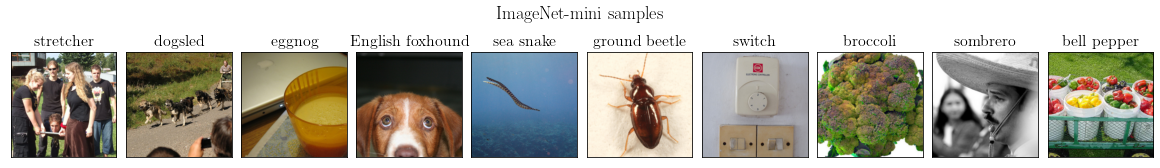

In [15]:
indices = np.random.choice(range(len(ds_val)), 10, replace=False)
in_mini_folder_to_class = get_imagenet_mini_foldername_to_classname(
    join(REPO_PATH, "cgn_framework/imagenet/data/in-mini/metadata.txt")
)

images, classes = [], []
for i in indices:
    sample = ds_val[i]
    images.append(sample["ims"])
    folder_name = ds_val.classes[int(sample["labels"].data)]
    class_name = in_mini_folder_to_class[folder_name]
    classes.append(class_name)

show_multiple_images(
    images,
    n_cols=10,
    normalized=True,
    figsize=(16, 2.5),
    title="ImageNet-mini samples",
    subtitles=classes,
)

In [16]:
def display_result_for_mini_imagenet_sample(
        image: torch.Tensor,
        label: int,
        classes: list,
        save=False,
        suffix="sample",
        path="sample_gradcam_label_{}_index_{}.pdf",
        title=None,
        figsize=(14, 4),
    ):
    
    # get gradcam outputs
    outputs = ensemble_gradcam.apply(image, label)
    
    modes = ["shape", "texture", "bg", "avg"]
    images = [outputs["image"]] + [outputs[m + "_overlap"] for m in modes]

    class_name_map = lambda x: in_mini_folder_to_class[classes[x]]    
    y_true = class_name_map(outputs['gt_label'])

    subtitles = [f"Original ($y = {y_true}$)"] + \
        ["{} ($\hat y = {}$)".format(m.capitalize(), class_name_map(outputs[m + '_label'])) for m in modes]

    path = path.format(y_true, suffix)
    path = join(REPO_PATH, "experiments", "results", "plots", path)

    show_multiple_images(
        images,
        title=title,
        subtitles=subtitles,
        n_cols=len(images),
        normalized=False,
        figsize=figsize,
        save=save,
        path=path,
    )

In [17]:
ensemble_gradcam = EnsembleGradCAM(ensemble_model=model, gradcam_method="GradCAM")

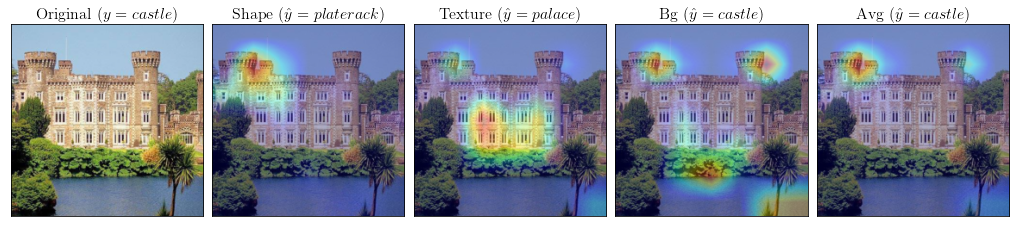

In [18]:
index = 1871
sample = ds_val[index]
display_result_for_mini_imagenet_sample(
    image=sample["ims"],
    label=sample["labels"],
    classes=ds_val.classes,
    suffix=index,
)

### Run an interpretability check on original sample

In [19]:
import ipywidgets as widgets
from IPython.display import display, Image

In [20]:
in_mini_class_to_folder = {v:k for k, v in in_mini_folder_to_class.items()}
in_mini_folder_to_index = {v: k for k, v in enumerate(ds_val.classes)}

In [21]:
df = pd.DataFrame(None, columns=["sample_index", "class_index", "class_folder", "class_name"])
df["sample_index"] = list(range(len(ds_val.labels))) 
df["class_index"] = ds_val.labels.astype(int)
df["class_folder"] = df["class_index"].apply(lambda x: ds_val.classes[x])
df["class_name"] = df["class_folder"].replace(in_mini_folder_to_class)

In [22]:
dropdown = widgets.Dropdown(
    description="Choose ImageNet class",
    options=in_mini_folder_to_class.values(),
    layout={'width': '50%'},
    style={'description_width': 'initial'},
)
out = widgets.Output(layout={'border': '1px solid black'})

In [23]:
display(dropdown)

Dropdown(description='Choose ImageNet class', layout=Layout(width='50%'), options=('kit fox', 'English setter'…

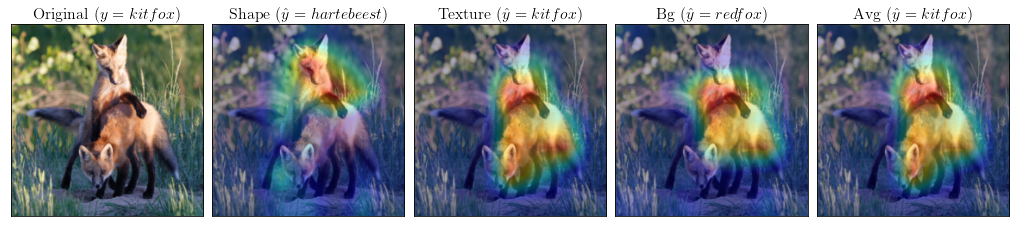

In [24]:
index = df[df.class_name == dropdown.value].sample(1).sample_index.values[0]
sample = ds_val[index]
display_result_for_mini_imagenet_sample(
    image=sample["ims"],
    label=sample["labels"],
    classes=ds_val.classes,
    suffix=index,
)

## Visualize focus-areas on counterfactual samples

In [25]:
# load CGN model
cgn = CGN(batch_sz=1, pretrained=False)

# load weights and push to GPU
weights = torch.load(join(REPO_PATH, 'cgn_framework/imagenet/weights/cgn.pth'), map_location='cpu')
cgn.load_state_dict(weights)
cgn.eval().to(device);

In [26]:
def display_result_for_counterfactual_sample(ys, classes=ds_val.classes, clf_transforms=ds_val.T_ims):

    # Generate the output
    # print(":: Generating CF sample ...")
    with torch.no_grad():
        x_gt, mask, premask, foreground, background, bg_mask = cgn(ys=ys)
        x_gen = mask * foreground + (1 - mask) * background
    
    # preprocess the image before send it to the classifier model
    # print(":: Preprocessing CF sample ...")
    image = x_gen[0]
    pil_image = transforms.ToPILImage()((image + 1) * 0.5)
    transformed_image = clf_transforms(pil_image)
    
    # print(":: Generating GradCAM output ...")
    class_name_map = lambda x: in_mini_folder_to_class[classes[x]]
    title = "CF example generated using Shape: {}  \t Texture: {}  \t BG: {}".format(
        class_name_map(ys[0]), class_name_map(ys[1]), class_name_map(ys[2]),
    )
    display_result_for_mini_imagenet_sample(
        image=transformed_image,
        label=torch.tensor(ys[0]),
        classes=classes,
        suffix=index,
        title=title,
        figsize=(14, 3)
    )

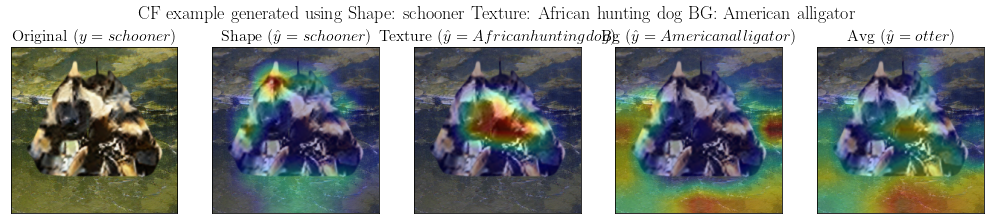

In [27]:
display_result_for_counterfactual_sample(ys=[780, 275, 50])

In [28]:
# define dropdowns
shape_dd = widgets.Dropdown(
    description="Choose shape",
    options=in_mini_folder_to_class.values(),
    layout={'width': '50%'},
    style={'description_width': 'initial'},
)

texture_dd = widgets.Dropdown(
    description="Choose texture",
    options=in_mini_folder_to_class.values(),
    layout={'width': '50%'},
    style={'description_width': 'initial'},
)

background_dd = widgets.Dropdown(
    description="Choose background",
    options=in_mini_folder_to_class.values(),
    layout={'width': '50%'},
    style={'description_width': 'initial'},
)

display(widgets.VBox([shape_dd, texture_dd, background_dd]))

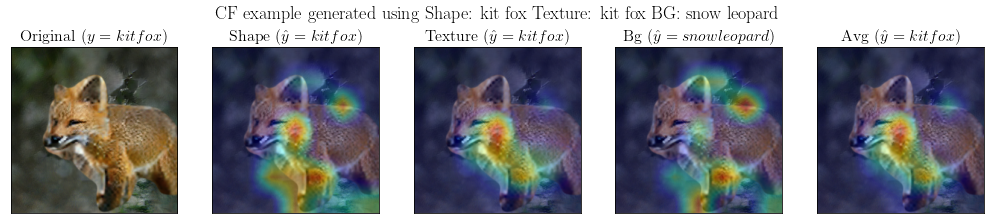

In [30]:
ys = [
    df[df.class_name == shape_dd.value].class_index.unique()[0],
    df[df.class_name == texture_dd.value].class_index.unique()[0],
    df[df.class_name == background_dd.value].class_index.unique()[0],
]
display_result_for_counterfactual_sample(ys=ys)